###**Importing API & Libraries**

In [2]:
import gzip
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from google.colab import drive

# Importing the required Keras modules containing model and layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D

from google.colab import files
from keras.preprocessing import image
from PIL import Image, ImageDraw, ImageOps
import cv2

###**Loading Dataset From Drive**

In [3]:
drive.mount('/content/drive/')

f = gzip.open('/content/drive/MyDrive/Project/Project_BHDR/bhand.pkl.gz','rb')
trainSet,validSet,testSet = pickle.load(f,encoding="latin1")
f.close()

Mounted at /content/drive/


###**Preprocessing Data**

In [4]:

def make_square(im, min_size=30, fill_color=(0)):
  x, y = im.size
  size = max(min_size, x, y)
  new_im = Image.new('L', (size, size), fill_color)
  new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
  return new_im.resize((30,30))
def convert2bit(im,x=32):
  for i in range(x): # Outer loop  
    for j in range(x): # inner loop  
      if(im[i][j]<=0.5):
        im[i][j]=0.0 
def pre_prosess(path):
  fig = plt.figure(figsize=(9, 12))
  fig.subplots_adjust(left=0, right=2, bottom=0, top=2)

  im= cv2.imread(path,0)

  fig.add_subplot(1, 4, 1)
  plt.imshow(im, 'gray')
  plt.title(im.shape)
  plt.xlabel("Uploaded Image",fontsize=14)

  img_reverted= cv2.bitwise_not(im)
  im = img_reverted / 255
  #print(type(im))

  convert2bit(im,x=180) 
  #print(im)
  #print(im.shape)

  fig.add_subplot(1, 4, 2)
  plt.imshow(im, cmap=plt.cm.binary)
  plt.title(im.shape)
  plt.xlabel("BG Noise Cleared",fontsize=14)
  plt.ylabel("↓ ",fontsize=25)

  im= im.reshape(180,180,1)
  #print(im)
  im = image.array_to_img(im)
  #print(image.img_to_array(im).shape)

  imResize = im.crop(im.getbbox())

  fig.add_subplot(1, 4, 3)
  plt.imshow(imResize, cmap=plt.cm.binary)
  plt.title(image.img_to_array(imResize).shape)
  plt.xlabel("Croped Extra BG",fontsize=14)
  plt.ylabel("↓ ",fontsize=25)

  #print(image.img_to_array(imResize).shape)
  imResize = make_square(imResize)
  #imResize.show()
  # plt.imshow(imResize, cmap=plt.cm.binary)
  # plt.show()
  # print(image.img_to_array(imResize).shape)
  imResize = ImageOps.expand(imResize, border=1, fill=(0))

  fig.add_subplot(1, 4, 4)
  plt.imshow(imResize, cmap=plt.cm.binary)
  plt.title(image.img_to_array(imResize).shape)
  plt.xlabel("Fitted To Square",fontsize=14)
  plt.ylabel("↓ ",fontsize=25)
  plt.tight_layout()
  plt.show()
  #print(image.img_to_array(imResize).shape)
  im=image.img_to_array(imResize)

  return im

###**Reshaping Data**

In [5]:
print("TrainSet type: ",type(trainSet))
print("Shape: ", [len(a) for a in trainSet],end="\n\n")

print("Spliting TrainSet Tuple into X_train, y_train",end="\n\n")
X_train, y_train = trainSet
X_valid,y_valid = validSet
X_test,y_test = testSet

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_valid = pd.DataFrame(X_valid)


y_train= pd.DataFrame(y_train)
y_test= pd.DataFrame(y_test)
y_valid = pd.DataFrame(y_valid)

#marging trainSet and validSet
X_test = pd.concat([X_test,X_valid])
y_test = pd.concat([y_test,y_valid])

print("X_train type: ",type(X_train))
print("Shape: ", X_train.shape)
print("y_train type: ",type(y_train))
print("Shape: ", y_train.shape)

X_train.head()

TrainSet type:  <class 'tuple'>
Shape:  [50000, 50000]

Spliting TrainSet Tuple into X_train, y_train

X_train type:  <class 'pandas.core.frame.DataFrame'>
Shape:  (50000, 1024)
y_train type:  <class 'pandas.core.frame.DataFrame'>
Shape:  (50000, 1)


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print("Original Data Shape: ",end='')
print(X_train.shape)

print("\nTransforming a 50000x1024 dataframe to a 50000x32x32x1 4D tensor for Keras modelling.\n")

train_images = X_train.values.reshape(X_train.shape[0], 32, 32, 1)
test_images = X_test.values.reshape(X_test.shape[0], 32, 32, 1)
#valid_images = X_valid.values.reshape(X_valid.shape[0], 32, 32, 1)

print("Reshaped Data Shape: ",end='')
print(train_images.shape)
print(type(train_images))

Original Data Shape: (50000, 1024)

Transforming a 50000x1024 dataframe to a 50000x32x32x1 4D tensor for Keras modelling.

Reshaped Data Shape: (50000, 32, 32, 1)
<class 'numpy.ndarray'>


###**Visualizing Data**

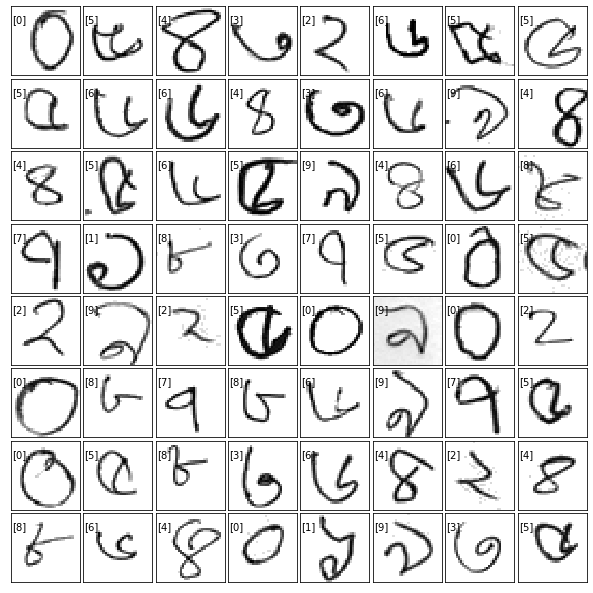

In [7]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 32x32 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(train_images[1000+i].reshape(32,32), cmap=plt.cm.binary, interpolation='nearest')
    
    # label of the image with the target value
    ax.text(0, 7, str(y_train.values[1000+i]))
plt.show()
print("")

###**Creating a model**

In [8]:
# Creating a Sequential Model and adding the layers
model = Sequential([
                      Conv2D(64,(3,3),input_shape=(32,32,1)),
                      MaxPool2D(2,2),
                      Flatten(),
                      Dense(128,activation='relu'),
                      Dropout(0.2),
                      Dense(10, input_shape=(train_images.shape[1],),activation='softmax')
])
# model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))

In [9]:
print("")

# Model Compile
print("========================== Compiling  model ==========================")
model.compile(optimizer='adam',metrics=['acc'],loss='sparse_categorical_crossentropy')
print("")

# Accuracy Callback
class handwriting_acc_callback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('acc')>=0.99):
       print("\n\nModel has reached >99% accuracy :)\n")
       self.model.stop_training = True

handwriting_acc_callback = handwriting_acc_callback()
print("")
# Model Fitting
print("============================= Model- Fit =============================")
model.fit(train_images,y_train,epochs=100,validation_split=.2,callbacks=[handwriting_acc_callback])
print("")
# Model Evaluation
print("========================== Model Evaluation ==========================")
model.evaluate(test_images,y_test)


========================== Compiling  model ==========================


============================= Model- Fit =============================
Epoch 1/100
1250/1250 [==============================] - 51s 40ms/step - loss: 0.3150 - acc: 0.9032 - val_loss: 0.1212 - val_acc: 0.9633
Epoch 2/100
1250/1250 [==============================] - 49s 39ms/step - loss: 0.1037 - acc: 0.9684 - val_loss: 0.0927 - val_acc: 0.9703
Epoch 3/100
1250/1250 [==============================] - 49s 39ms/step - loss: 0.0637 - acc: 0.9808 - val_loss: 0.0831 - val_acc: 0.9749
Epoch 4/100
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0440 - acc: 0.9865 - val_loss: 0.0888 - val_acc: 0.9752
Epoch 5/100
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0321 - acc: 0.9895 - val_loss: 0.0903 - val_acc: 0.9762
Epoch 6/100
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0310 - acc: 0.9894 - val_loss: 0.0838 - val_acc: 0.9764
Epoch 7/100
1249/1250 [==========

[0.12166155874729156, 0.9692500233650208]

###**Model Prediction Example**

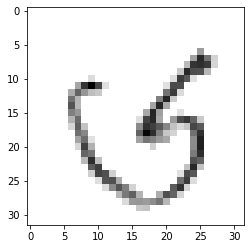

Predicted Value is: 6


In [10]:
from PIL import Image as im

n=150                      #a random input
array = X_valid.values[n]
array = array*255
array = np.reshape(array, (32, 32))

data = im.fromarray(array)
data = data.convert("L")
data = np.invert(data)

plt.imshow(data,cmap='gray')
plt.show()
class_label=model.predict(X_valid.values[n].reshape(1,32,32)).argmax()
print("Predicted Value is:",class_label)




In [11]:
pred=[]
lebel=np.array([])
for i in range(24):
    pred.append(model.predict(X_valid.values[i].reshape(1,32,32)).argmax())
    lebel=np.concatenate((lebel, y_valid.values[i]))

print(pred)
print(lebel)

[7, 0, 7, 1, 7, 4, 5, 7, 2, 1, 6, 5, 5, 2, 3, 2, 9, 3, 7, 3, 4, 4, 7, 8]
[7. 0. 7. 1. 7. 4. 5. 7. 2. 1. 6. 5. 5. 2. 3. 2. 1. 3. 7. 3. 4. 4. 7. 8.]


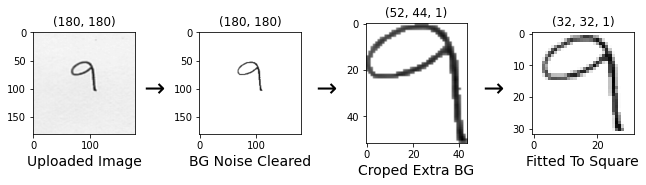

Predicted Value is: 7


In [12]:
im=pre_prosess('/content/drive/MyDrive/Project/Project_BHDR/test_image/d00142.png')
class_label=model.predict(im.reshape(1,32,32)).argmax()
print("Predicted Value is:",class_label)

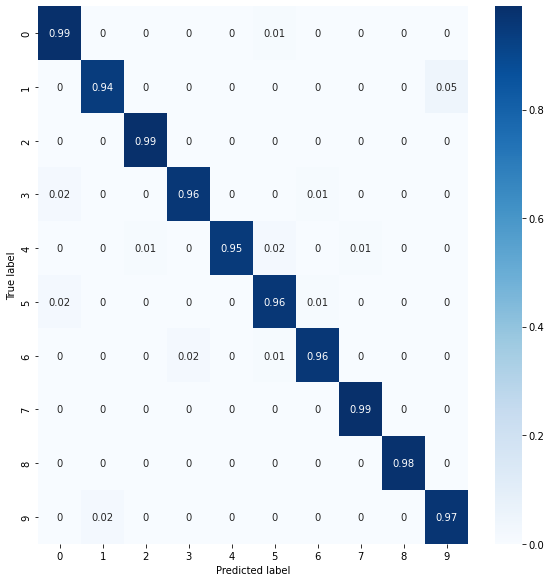

In [13]:
import seaborn as sns
classes=[0,1,2,3,4,5,6,7,8,9]
y_pred=model.predict(test_images)
y_pred=np.argmax(y_pred,axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
# Model Prediction
print("========================== Model Prediction ==========================")
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  im = image.load_img(path)

  x=pre_prosess(path)
  class_label = model.predict(x.reshape(1,32,32)).argmax()
  print("Predicted Value is:",class_label)

========================== Model Prediction ==========================


In [15]:

# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
# load the image
img = load_img("/content/drive/MyDrive/Project/Project_BHDR/test_image/d00016.png",0)
print(type(img))
img = img.convert('L')
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
#img_array = img_array.reshape(180,180,1)
# convert back to image
img_pil = array_to_img(img_array)

print(type(img_pil))

<class 'PIL.PngImagePlugin.PngImageFile'>
float32
(180, 180, 1)
<class 'PIL.Image.Image'>
